In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## Data and Motivations

So the idea here is to make a dog classifier from the [Stanford Dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). This is basically going to be the same as the pets classifier from the Fast.ai lesson one, but includes more dogs and fewer cats. (My real motivation is that my mom likes huskies and my sister likes german shorthairs, and neither were included in the Fast.ai pet classifier.)

This is my first time using Google Cloud and my first try at ML, so I'm going to list everything.

To get the dataset I first tried using the fastai function `untar_data`, but this threw the error `ReadError: not a gzip file` because the function expects a `.gz` and the Stanford file is `.tar`. Easy enough: I'm using Google Cloud, so I can just do: 

`wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar`

and then unpack it with:

`tar -xvf images.tar`

**Access to Gcloud**

When I first set up the VM it worked like a charm. But the next day when I started it back up I wasn't able to conect to Jupyter notebooks. The original command specified port 8080:

`gcloud compute ssh --zone=$ZONE jupyter@$INSTANCE_NAME -- -L 8080:localhost:8080`

I noticed that when I started the notebook the server was on `8889`. Reconnecting to the shell with port `8889` did the trick. (Although I'm not sure what changed from yesterday.)

## The first attempt

```python
images_path = "/home/jupyter/data/StanfordDogs/Images/"
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(images_path)
```

Unfortunately, this won't work, because the images aren't split up into subdirectories for `train`, `valid` and `test`, which is the standard for ImageNet-type datasets.

The current dataset is structured like so:

```
- Images/
  - n02110185-Siberian_husky
    + n02110185_184.jpg
    + ...
    + ...
```

(I also don't see german shorthair in this list. Oh well!)

So, basically, I need to split the images up such that `ImageDataBunch.from(folder)` can understand it. Like the following:

```
path\
  train\
    clas1\
    clas2\
    ...
  valid\
    clas1\
    clas2\
    ...
  test\
  ```
  
I recently read that people tend to use 50% to 90% for training and the rest for validation.
  
training data  | .      | .      | .      | test data
-------------- |--------|--------|--------|-----------
fold 1         | fold 2 | fold 3 | fold 4 | fold 5

I'll use folds 1-3 for training, fold 4 for validation and fold 5 for testing.

So I need a script that, for each dog folder, moves 60% of the images to `train/`, 20% to `valid` and 20% to `test`. While I'm at it I'll normalize the directory names to get better class names. (They're all over the place in terms of lower- and upper-case.)

## Husky Training

On a personal note, I code mostly at public libraries because I currently live in a cabin in the mountains. The well for water is powered by a generator, and there's no electricity or cell service, so no wifi either. This is great for learning to code without searching for online solutions, and it's great for other things: studying math, reading papers, and growing vegetables. But it's not super great when I'm flowing and the library closes. In the case of this notebook I wanted to keep going. Because I'm working on a small MacBook and that I don't see a German shorthair category (TBH, I haven't looked thoroughly), I've decided to train this CNN solely on Siberian huskies. Huskies are hot dogs, too.

Below are the counts for folders `train`, `valid` and `test`, weighing in at 116, 38 and 38, respectively, and reflecting the folds described above. I used this [simple script](./folderify.py) to divide and copy the set of images. It's not a work of art, but it's there if in the future I want to train with the whole set. I'm sort of new to Python and small things take longer, such as `for index, item in enumerate(p.iterdir()):`. 

```bash
➜  Images git:(master) ✗ ls -R train | wc -l
     116
➜  Images git:(master) ✗ ls -R valid | wc -l
      38
➜  Images git:(master) ✗ ls -R test | wc -l
      38
```

I'm hoping to go back to the first attempt and load the data, perhaps even train the model.

In [3]:
path = Path("./data")
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=112, bs=64).normalize(imagenet_stats)

In [4]:
data.classes

['pug', 'siberian_husky', 'standard_poodle']

🚀

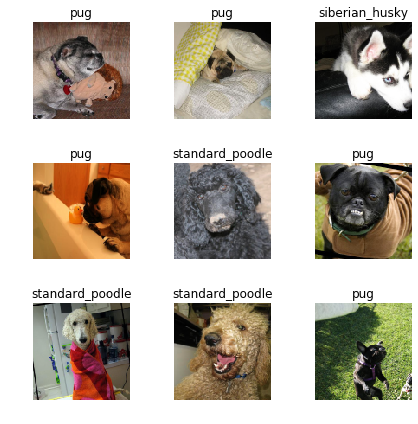

In [5]:
data.show_batch(rows=3, figsize=(6,6))

Cool, data is loading. I can see pictures of dogs (the hidden goal). But there's a problem. This dataset has only one class (`siberian_husky`). I don't know much, and this brings up a question, how many classes are needed? 

To be sure, I'm only interested (now) in knowing if `X` contains a husky. Will training only one class get the model there? Or, do you need more classes? My intuition tells me the model needs multiple classes -- but  that's perhaps because I've only seen examples with multiple classes.

Also, there's an argument for why the model could function fine with one class. Say a model is trained with three classes: A, B and C. Given an input, a prediction would would be returned for all three classes `{a: x, b: y, c: z}`. More classes could also be added, `n + 1`. Three is not the limit. Provided with input images, the model would return weights for each class. So, if classes can be added _and_ one class's output does not depend on another class's output, then classes can also be subtracted, with one class being the minimum. 

This brings up another question, what about if A and B show up in the same image? How does the CNN handle that? Here's the fun part about making things: experimenting. 

## The New Experiment

Given two CNNs, one trained with a single class and the other trained with multiple classes, and some set of husky images, will the two CNNs output the same scores for the same set of images?

The next step is to learn the model! 

```python
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
```

Alas, that will have to wait until I'm back online: 

> Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/.cache/torch/checkpoints/resnet34-333f7ec4.pth
>
> URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

### German Shorthairs

Going back to the data, I'm reasonably certain there isn't a class for German shorthairs, unless they're called something else.

```bash
StandfordDogs git:(master) ✗ ls -l | grep 'shorthair'
∅
StandfordDogs git:(master) ✗ ls -l | grep 'german'
∅
StandfordDogs git:(master) ✗ ls -l | grep 'pug'       
drwxr-xr-x  202 home  group  6464 Oct  9  2011 n02110958-pug
```

Well this isn't super promising:

![](./images/zero-loss-rate.png)

I diffed the outputs from the `learn.model` above and from `lesson1-pets`. The only difference was in the last line:

> (8): Linear(in_features=512, out_features=1, bias=True)

`lesson1-pets` has `out_features=37`, which is the same number as output by `len(data.classes)`. 

I'm going to try adding another two classes and see what changes.

So, it is better with two classes! Losses and errors are greater than zero! 

![](./images/husky-pug.png)

I wonder if the losses and errors will increase again when new classes are added. Let's see.

![](./images/husky-pug-poodle.png)

Now there are three classes, husky, pug and standard poodle. The training time increased by about 1.5, training loss increased 1.12 and valid loss decreased by 0.6.

In [6]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.227783,0.310239,0.136364,00:16
1,0.206322,0.321165,0.154545,00:16


In [11]:
learn.save('stage-1')

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

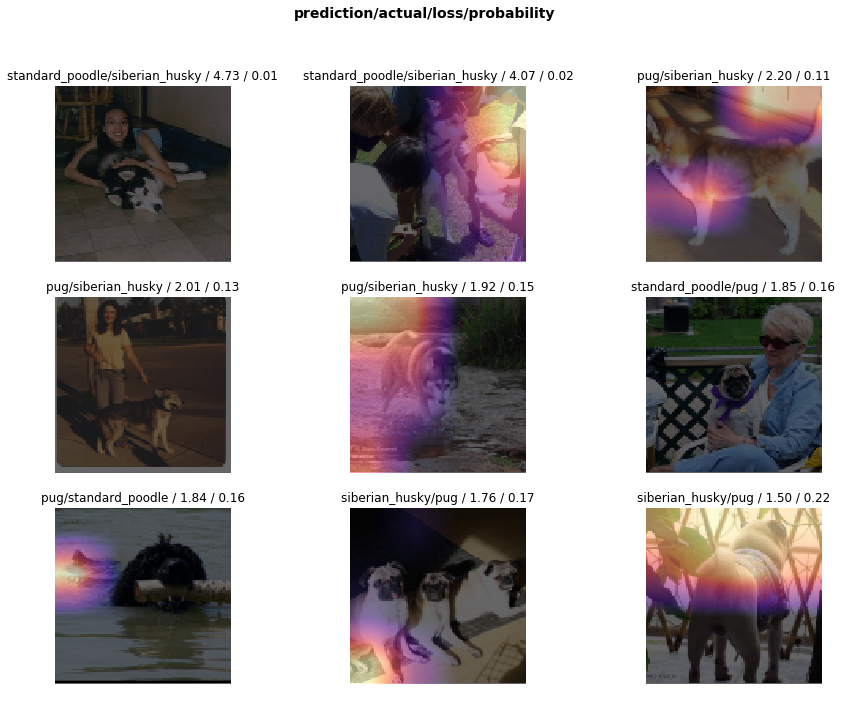

In [14]:
interp.plot_top_losses(9, figsize=(15,11))

In [15]:
doc(interp.plot_top_losses)

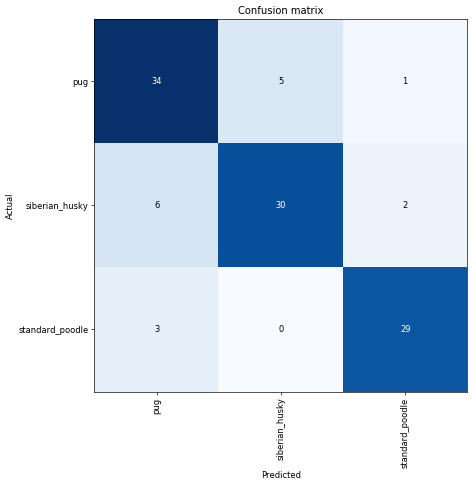

In [18]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [19]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.146616,1.408538,0.236364,00:22
1,0.112277,1.016648,0.236364,00:21


In [23]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (333 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
standard_poodle,standard_poodle,standard_poodle,standard_poodle,standard_poodle
Path: data;

Valid: LabelList (110 items)
x: ImageList
Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112),Image (3, 112, 112)
y: CategoryList
standard_poodle,standard_poodle,standard_poodle,standard_poodle,standard_poodle
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


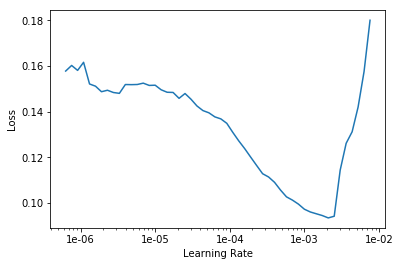

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.185307,0.326137,0.154545,00:23
1,0.178645,0.324674,0.154545,00:25


In [27]:
learn.save('stage-2')

In [28]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 56, 56]         9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
______________________________________________________________________
MaxPool2d            [64, 28, 28]         0          False     
______________________________________________________________________
Conv2d               [64, 28, 28]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 28, 28]         128        True      
______________________________________________________________________
ReLU                 [64, 28, 28]         0          False     
___________________________________________________

## All the Dogs

This version of the dog classifier uses the entire dataset. Even if you only wanted to identify one dog, the classifier will be stronger if it can work for many categories. 

In [3]:
from Rekennel import Rekennel

In [5]:
rk = Rekennel('./StanfordDogs', './data')
rk.move()

StanfordDogs/n02112137-chow/n02112137_8595.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_2106.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_2619.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_3570.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_5742.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_1614.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_16777.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_7751.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_2411.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_14751.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_14448.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_8212.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_13649.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_16665.jpg  ->  data/train/chow
StanfordDogs/n02112137-chow/n02112137_6164.

StanfordDogs/n02102318-cocker_spaniel/n02102318_10162.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_10618.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_14892.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_9254.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_2030.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_11228.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_12887.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_9452.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_2048.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_11865.jpg  ->  data/train/cocker_spaniel
StanfordDogs/n02102318-cocker_spaniel/n02102318_6105.jpg  ->  data/valid/cocker_spaniel
StanfordDogs/n02102318-coc

StanfordDogs/n02088364-beagle/n02088364_16065.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_5427.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_5784.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_17314.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_13028.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_16210.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_14911.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_13478.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_15877.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_8871.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_2566.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_13627.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_12213.jpg  ->  data/test/beagle
StanfordDogs/n02088364-beagle/n02088364_8820.jpg  ->  data/test/beag

StanfordDogs/n02106550-Rottweiler/n02106550_13226.jpg  ->  data/train/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_7616.jpg  ->  data/train/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_8595.jpg  ->  data/train/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_11244.jpg  ->  data/train/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_4920.jpg  ->  data/train/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_10706.jpg  ->  data/train/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_1366.jpg  ->  data/train/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_2323.jpg  ->  data/valid/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_8437.jpg  ->  data/valid/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_1889.jpg  ->  data/valid/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_6599.jpg  ->  data/valid/rottweiler
StanfordDogs/n02106550-Rottweiler/n02106550_6402.jpg  ->  data/valid/rottweiler
StanfordDogs/n02106550-Rottweiler/n02

StanfordDogs/n02101556-clumber/n02101556_8243.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_3896.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_4017.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_2623.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_374.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_7528.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_1018.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_5940.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_3909.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_2694.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_2604.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_3901.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_5771.jpg  ->  data/test/clumber
StanfordDogs/n02101556-clumber/n02101556_2715.jpg  -

StanfordDogs/n02091244-Ibizan_hound/n02091244_1045.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_226.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_2542.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_4281.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_1238.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_4948.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_327.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_3921.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_5989.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_1030.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_4242.jpg  ->  data/train/ibizan_hound
StanfordDogs/n02091244-Ibizan_hound/n02091244_430.jpg  ->  data/train/ibizan_h

StanfordDogs/n02116738-African_hunting_dog/n02116738_6297.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_5519.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_1927.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_6754.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_10493.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_7060.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_5312.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_4991.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_8037.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-African_hunting_dog/n02116738_8945.jpg  ->  data/test/african_hunting_dog
StanfordDogs/n02116738-Africa

StanfordDogs/n02086240-Shih-Tzu/n02086240_5703.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_7209.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_135.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_5994.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_10785.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_7142.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_2961.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_126.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_8205.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_968.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_1267.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_1333.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_1016.jpg  ->  data/train/shih
StanfordDogs/n02086240-Shih-Tzu/n02086240_533.jpg  ->  data/train/

StanfordDogs/n02098105-soft-coated_wheaten_terrier/n02098105_344.jpg  ->  data/test/soft
StanfordDogs/n02098105-soft-coated_wheaten_terrier/n02098105_3374.jpg  ->  data/test/soft
StanfordDogs/n02098105-soft-coated_wheaten_terrier/n02098105_2842.jpg  ->  data/test/soft
StanfordDogs/n02098105-soft-coated_wheaten_terrier/n02098105_2897.jpg  ->  data/test/soft
StanfordDogs/n02098105-soft-coated_wheaten_terrier/n02098105_2404.jpg  ->  data/test/soft
StanfordDogs/n02098105-soft-coated_wheaten_terrier/n02098105_1067.jpg  ->  data/test/soft
StanfordDogs/n02098105-soft-coated_wheaten_terrier/n02098105_82.jpg  ->  data/test/soft
StanfordDogs/n02094433-Yorkshire_terrier/n02094433_4005.jpg  ->  data/train/yorkshire_terrier
StanfordDogs/n02094433-Yorkshire_terrier/n02094433_4214.jpg  ->  data/train/yorkshire_terrier
StanfordDogs/n02094433-Yorkshire_terrier/n02094433_2782.jpg  ->  data/train/yorkshire_terrier
StanfordDogs/n02094433-Yorkshire_terrier/n02094433_8419.jpg  ->  data/train/yorkshire_terri

StanfordDogs/n02113023-Pembroke/n02113023_2330.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_1198.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_11103.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_15144.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_14262.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_1354.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_11397.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_9306.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_4024.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_4782.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_10829.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_6177.jpg  ->  data/test/pembroke
StanfordDogs/n02113023-Pembroke/n02113023_3509.jpg  ->  data/test/pembroke
StanfordDogs/n021130

StanfordDogs/n02092339-Weimaraner/n02092339_1509.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_436.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_748.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_286.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_3212.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_512.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_1100.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_767.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_4906.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_5313.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_3371.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_5411.jpg  ->  data/train/weimaraner
StanfordDogs/n02092339-Weimaraner/n02092339_3

StanfordDogs/n02100877-Irish_setter/n02100877_4724.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_4700.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_5883.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_6214.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_4699.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_151.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_2551.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_592.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_3463.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_3195.jpg  ->  data/test/irish_setter
StanfordDogs/n02100877-Irish_setter/n02100877_738.jpg  ->  data/test/irish_setter
StanfordDogs/n02109961-Eskimo_dog/n02109961_20429.jpg  ->  data/train/eskimo_dog
StanfordD

StanfordDogs/n02104029-kuvasz/n02104029_1370.jpg  ->  data/train/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_1400.jpg  ->  data/train/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_3787.jpg  ->  data/train/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_4415.jpg  ->  data/train/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_690.jpg  ->  data/train/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_247.jpg  ->  data/train/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_4091.jpg  ->  data/train/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_1375.jpg  ->  data/valid/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_897.jpg  ->  data/valid/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_3166.jpg  ->  data/valid/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_4473.jpg  ->  data/valid/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_409.jpg  ->  data/valid/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_4800.jpg  ->  data/valid/kuvasz
StanfordDogs/n02104029-kuvasz/n02104029_2861.jpg  ->  data/valid/kuv

StanfordDogs/n02107683-Bernese_mountain_dog/n02107683_4168.jpg  ->  data/test/bernese_mountain_dog
StanfordDogs/n02107683-Bernese_mountain_dog/n02107683_4810.jpg  ->  data/test/bernese_mountain_dog
StanfordDogs/n02107683-Bernese_mountain_dog/n02107683_7104.jpg  ->  data/test/bernese_mountain_dog
StanfordDogs/n02087394-Rhodesian_ridgeback/n02087394_11116.jpg  ->  data/train/rhodesian_ridgeback
StanfordDogs/n02087394-Rhodesian_ridgeback/n02087394_9462.jpg  ->  data/train/rhodesian_ridgeback
StanfordDogs/n02087394-Rhodesian_ridgeback/n02087394_261.jpg  ->  data/train/rhodesian_ridgeback
StanfordDogs/n02087394-Rhodesian_ridgeback/n02087394_1706.jpg  ->  data/train/rhodesian_ridgeback
StanfordDogs/n02087394-Rhodesian_ridgeback/n02087394_3275.jpg  ->  data/train/rhodesian_ridgeback
StanfordDogs/n02087394-Rhodesian_ridgeback/n02087394_8993.jpg  ->  data/train/rhodesian_ridgeback
StanfordDogs/n02087394-Rhodesian_ridgeback/n02087394_3072.jpg  ->  data/train/rhodesian_ridgeback
StanfordDogs/n020

StanfordDogs/n02088632-bluetick/n02088632_610.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_597.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_3699.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_650.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_4687.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_1592.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_4360.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_874.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_1108.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_4157.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_4002.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_562.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick/n02088632_613.jpg  ->  data/test/bluetick
StanfordDogs/n02088632-bluetick

StanfordDogs/n02102040-English_springer/n02102040_5133.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_2635.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_3798.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_358.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_763.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_1976.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_3984.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_3006.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_661.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_4956.jpg  ->  data/test/english_springer
StanfordDogs/n02102040-English_springer/n02102040_8210.jpg  ->  data/test/english_springer
St

StanfordDogs/n02102480-Sussex_spaniel/n02102480_8117.jpg  ->  data/train/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_582.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_2224.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_7854.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_7690.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_4244.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_5514.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_7189.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_4365.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_366.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_spaniel/n02102480_7417.jpg  ->  data/valid/sussex_spaniel
StanfordDogs/n02102480-Sussex_span

StanfordDogs/n02099429-curly_coated_retriever/n02099429_212.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_3193.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_3276.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_1412.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_2699.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_1883.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_3213.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_841.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_1773.jpg  ->  data/train/curly_coated_retriever
StanfordDogs/n02099429-curly_coated_retriever/n02099429_664.jpg  -

StanfordDogs/n02086079-Pekinese/n02086079_1759.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_5522.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_16693.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_10932.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_14929.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_4129.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_2358.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_6096.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_17103.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_186.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_21103.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_356.jpg  ->  data/train/pekinese
StanfordDogs/n02086079-Pekinese/n02086079_3832.jpg  ->  data/train/pekinese
StanfordD

StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_3872.jpg  ->  data/train/staffordshire_bullterrier
StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_2817.jpg  ->  data/train/staffordshire_bullterrier
StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_5647.jpg  ->  data/train/staffordshire_bullterrier
StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_3190.jpg  ->  data/train/staffordshire_bullterrier
StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_6821.jpg  ->  data/train/staffordshire_bullterrier
StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_2353.jpg  ->  data/train/staffordshire_bullterrier
StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_1505.jpg  ->  data/train/staffordshire_bullterrier
StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_6077.jpg  ->  data/train/staffordshire_bullterrier
StanfordDogs/n02093256-Staffordshire_bullterrier/n02093256_911.jpg  ->  data/train/staffordshire_bullterrier
StanfordDog

StanfordDogs/n02091831-Saluki/n02091831_2995.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_13566.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_7244.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_1439.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_566.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_2911.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_8401.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_1118.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_10593.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_7497.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_4980.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_5745.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_4667.jpg  ->  data/test/saluki
StanfordDogs/n02091831-Saluki/n02091831_3064.jpg  ->  data/test/saluki
Stanf

StanfordDogs/n02113186-Cardigan/n02113186_6415.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_748.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_10816.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_11220.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_6173.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_2431.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_6539.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_3178.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_3049.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_12316.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_10416.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_7608.jpg  ->  data/train/cardigan
StanfordDogs/n02113186-Cardigan/n02113186_7480.jpg  ->  data/train/cardigan
StanfordD

StanfordDogs/n02091134-whippet/n02091134_13879.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_4149.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_18902.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_11775.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_10690.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_4197.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_2193.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_10548.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_18069.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_15210.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_1129.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_12341.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_14002.jpg  ->  data/test/whippet
StanfordDogs/n02091134-whippet/n02091134_1

StanfordDogs/n02110063-malamute/n02110063_14381.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_7037.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_6508.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_11892.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_15327.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_1058.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_14141.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_11887.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_14327.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_17474.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_18180.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_11585.jpg  ->  data/train/malamute
StanfordDogs/n02110063-malamute/n02110063_4432.jpg  ->  data/train/malamute
Sta

StanfordDogs/n02090622-borzoi/n02090622_9883.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_5045.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_5775.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_5524.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_3615.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_8338.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_5057.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_7489.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_7602.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_5098.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_2055.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_3300.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_7409.jpg  ->  data/valid/borzoi
StanfordDogs/n02090622-borzoi/n02090622_7905.jpg  ->  data/valid

StanfordDogs/n02099601-golden_retriever/n02099601_100.jpg  ->  data/test/golden_retriever
StanfordDogs/n02099601-golden_retriever/n02099601_3720.jpg  ->  data/test/golden_retriever
StanfordDogs/n02099601-golden_retriever/n02099601_5366.jpg  ->  data/test/golden_retriever
StanfordDogs/n02099601-golden_retriever/n02099601_6233.jpg  ->  data/test/golden_retriever
StanfordDogs/n02099601-golden_retriever/n02099601_7437.jpg  ->  data/test/golden_retriever
StanfordDogs/n02099601-golden_retriever/n02099601_2536.jpg  ->  data/test/golden_retriever
StanfordDogs/n02099601-golden_retriever/n02099601_8764.jpg  ->  data/test/golden_retriever
StanfordDogs/n02099601-golden_retriever/n02099601_215.jpg  ->  data/test/golden_retriever
StanfordDogs/n02097209-standard_schnauzer/n02097209_2087.jpg  ->  data/train/standard_schnauzer
StanfordDogs/n02097209-standard_schnauzer/n02097209_2205.jpg  ->  data/train/standard_schnauzer
StanfordDogs/n02097209-standard_schnauzer/n02097209_2382.jpg  ->  data/train/stand

StanfordDogs/n02109047-Great_Dane/n02109047_13072.jpg  ->  data/train/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_28433.jpg  ->  data/train/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_12569.jpg  ->  data/train/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_11472.jpg  ->  data/train/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_5181.jpg  ->  data/valid/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_5894.jpg  ->  data/valid/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_23483.jpg  ->  data/valid/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_22413.jpg  ->  data/valid/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_13730.jpg  ->  data/valid/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_941.jpg  ->  data/valid/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_12085.jpg  ->  data/valid/great_dane
StanfordDogs/n02109047-Great_Dane/n02109047_5331.jpg  ->  data/valid/great_dane
StanfordDogs/n02109047-Great_Dane

StanfordDogs/n02088094-Afghan_hound/n02088094_13907.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_12563.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_5326.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_4049.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_13442.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_12867.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_3620.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_4635.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_1932.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_7894.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_3596.jpg  ->  data/train/afghan_hound
StanfordDogs/n02088094-Afghan_hound/n02088094_4464.jpg  ->  data/train/a

StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_1661.jpg  ->  data/train/greater_swiss_mountain_dog
StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_2033.jpg  ->  data/train/greater_swiss_mountain_dog
StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_1441.jpg  ->  data/train/greater_swiss_mountain_dog
StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_1261.jpg  ->  data/train/greater_swiss_mountain_dog
StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_380.jpg  ->  data/train/greater_swiss_mountain_dog
StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_2806.jpg  ->  data/train/greater_swiss_mountain_dog
StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_1531.jpg  ->  data/train/greater_swiss_mountain_dog
StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_1101.jpg  ->  data/train/greater_swiss_mountain_dog
StanfordDogs/n02107574-Greater_Swiss_Mountain_dog/n02107574_417.jpg  ->  data/train/greater_swiss_mountai

StanfordDogs/n02086646-Blenheim_spaniel/n02086646_280.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_3738.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_2641.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_3059.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_2173.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_471.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_1757.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_2815.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_1150.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_2404.jpg  ->  data/test/blenheim_spaniel
StanfordDogs/n02086646-Blenheim_spaniel/n02086646_296.jpg  ->  data/test/blenheim_spaniel
St

StanfordDogs/n02112018-Pomeranian/n02112018_2699.jpg  ->  data/train/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_2790.jpg  ->  data/train/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_11557.jpg  ->  data/train/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_554.jpg  ->  data/train/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_1659.jpg  ->  data/train/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_1495.jpg  ->  data/train/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_2380.jpg  ->  data/train/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_7341.jpg  ->  data/valid/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_5089.jpg  ->  data/valid/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_1146.jpg  ->  data/valid/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_3126.jpg  ->  data/valid/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112018_9753.jpg  ->  data/valid/pomeranian
StanfordDogs/n02112018-Pomeranian/n02112

StanfordDogs/n02093991-Irish_terrier/n02093991_168.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_3918.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_199.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_1179.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_3300.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_946.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_1394.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_1684.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_4866.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_3383.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_130.jpg  ->  data/test/irish_terrier
StanfordDogs/n02093991-Irish_terrier/n02093991_592.jpg  ->  data/test

StanfordDogs/n02099712-Labrador_retriever/n02099712_7866.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_4550.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_2332.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_4462.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_2938.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_4354.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_7414.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_6646.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_3258.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retriever/n02099712_7605.jpg  ->  data/train/labrador_retriever
StanfordDogs/n02099712-Labrador_retrieve

StanfordDogs/n02088238-basset/n02088238_3475.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_2009.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_11846.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_2646.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_10054.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_6035.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_8520.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_2674.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_6017.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_517.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_11383.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_10757.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_11339.jpg  ->  data/train/basset
StanfordDogs/n02088238-basset/n02088238_5441.jpg  ->  data/t

StanfordDogs/n02097298-Scotch_terrier/n02097298_7115.jpg  ->  data/test/scotch_terrier
StanfordDogs/n02097298-Scotch_terrier/n02097298_8911.jpg  ->  data/test/scotch_terrier
StanfordDogs/n02097298-Scotch_terrier/n02097298_6110.jpg  ->  data/test/scotch_terrier
StanfordDogs/n02097298-Scotch_terrier/n02097298_132.jpg  ->  data/test/scotch_terrier
StanfordDogs/n02097298-Scotch_terrier/n02097298_8322.jpg  ->  data/test/scotch_terrier
StanfordDogs/n02097298-Scotch_terrier/n02097298_6276.jpg  ->  data/test/scotch_terrier
StanfordDogs/n02097298-Scotch_terrier/n02097298_91.jpg  ->  data/test/scotch_terrier
StanfordDogs/n02097298-Scotch_terrier/n02097298_344.jpg  ->  data/test/scotch_terrier
StanfordDogs/n02099849-Chesapeake_Bay_retriever/n02099849_3207.jpg  ->  data/train/chesapeake_bay_retriever
StanfordDogs/n02099849-Chesapeake_Bay_retriever/n02099849_3812.jpg  ->  data/train/chesapeake_bay_retriever
StanfordDogs/n02099849-Chesapeake_Bay_retriever/n02099849_696.jpg  ->  data/train/chesapeake

StanfordDogs/n02096177-cairn/n02096177_1710.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_6083.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_9528.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_6555.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_1220.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_13328.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_9014.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_7701.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_4916.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_207.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_2127.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_5274.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_1889.jpg  ->  data/train/cairn
StanfordDogs/n02096177-cairn/n02096177_2560.jpg  ->  data/train/cairn
StanfordDogs/n020961

StanfordDogs/n02087046-toy_terrier/n02087046_5219.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_505.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_3608.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_4315.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_6443.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_7960.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_4455.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_4350.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_4102.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_924.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_5626.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_terrier/n02087046_5847.jpg  ->  data/test/toy_terrier
StanfordDogs/n02087046-toy_ter

StanfordDogs/n02111129-Leonberg/n02111129_4246.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_3367.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_1788.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_5300.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_2924.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_1662.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_1480.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_4698.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_1390.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_4533.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_658.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_4792.jpg  ->  data/train/leonberg
StanfordDogs/n02111129-Leonberg/n02111129_3884.jpg  ->  data/train/leonberg
StanfordDogs/

StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_1986.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_3272.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_3140.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_998.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_536.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_132.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_1733.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_1852.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_3113.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_2114.jpg  ->  data/test/kerry_blue_terrier
StanfordDogs/n02093859-Kerry_blue_terrier/n02093859_1

StanfordDogs/n02096585-Boston_bull/n02096585_5043.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_1069.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_2696.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_9153.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_2260.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_2374.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_3697.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_12168.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_32.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_2394.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_7859.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston_bull/n02096585_2671.jpg  ->  data/test/boston_bull
StanfordDogs/n02096585-Boston

StanfordDogs/n02107312-miniature_pinscher/n02107312_6487.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_7235.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_7147.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_3470.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_7214.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_7725.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_5055.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_1195.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_3624.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinscher/n02107312_5665.jpg  ->  data/train/miniature_pinscher
StanfordDogs/n02107312-miniature_pinsche

StanfordDogs/n02102973-Irish_water_spaniel/n02102973_3149.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_2958.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_399.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_23.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_1725.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_1622.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_2727.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_2453.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_2595.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-Irish_water_spaniel/n02102973_2220.jpg  ->  data/train/irish_water_spaniel
StanfordDogs/n02102973-

StanfordDogs/n02090721-Irish_wolfhound/n02090721_2254.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_3564.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_4089.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_1931.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_2536.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_4353.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_1349.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_2179.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_969.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_7104.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721-Irish_wolfhound/n02090721_4376.jpg  ->  data/test/irish_wolfhound
StanfordDogs/n02090721

StanfordDogs/n02094114-Norfolk_terrier/n02094114_1076.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_1020.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_1698.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_2706.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_3920.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_3890.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_3172.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_1595.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_61.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_2785.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-Norfolk_terrier/n02094114_787.jpg  ->  data/test/norfolk_terrier
StanfordDogs/n02094114-N

StanfordDogs/n02097474-Tibetan_terrier/n02097474_7413.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_1728.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_2598.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_2928.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_5140.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_6916.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_1859.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_8811.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_5786.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_7598.jpg  ->  data/train/tibetan_terrier
StanfordDogs/n02097474-Tibetan_terrier/n02097474_425.jpg  ->  data/train/tibetan_terrier
StanfordDog

StanfordDogs/n02105855-Shetland_sheepdog/n02105855_13382.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_2853.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_17893.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_15506.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_13611.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_13407.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_16145.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_14081.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_7717.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_15067.jpg  ->  data/test/shetland_sheepdog
StanfordDogs/n02105855-Shetland_sheepdog/n02105855_3549.jpg  -

StanfordDogs/n02085936-Maltese_dog/n02085936_8767.jpg  ->  data/train/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_18114.jpg  ->  data/train/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_3451.jpg  ->  data/train/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_1739.jpg  ->  data/train/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_3678.jpg  ->  data/train/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_24178.jpg  ->  data/train/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_6034.jpg  ->  data/valid/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_22127.jpg  ->  data/valid/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_6927.jpg  ->  data/valid/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_4929.jpg  ->  data/valid/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_11541.jpg  ->  data/valid/maltese_dog
StanfordDogs/n02085936-Maltese_dog/n02085936_24464.jpg  ->  data/valid/maltese_dog
StanfordDog

StanfordDogs/n02112350-keeshond/n02112350_3824.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_9987.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_8628.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_7837.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_9112.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_3314.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_1572.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_212.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_7789.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_9536.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_9545.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_8390.jpg  ->  data/train/keeshond
StanfordDogs/n02112350-keeshond/n02112350_1050.jpg  ->  data/train/keeshond
StanfordDogs/

In [3]:
path = Path("./data")
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=112, bs=64).normalize(imagenet_stats)

In [4]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly_coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat',
 'french_bulldog',
 'german_shepherd',
 'german_short',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',
 'ibizan_hound',
 'irish_setter',
 'irish_terrier',
 'irish_

In [5]:
data.c == len(data.classes)

True

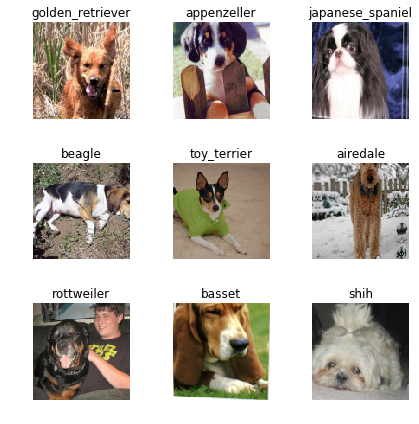

In [10]:
data.show_batch(rows=3, figsize=(6,6))

In [6]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [35]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,2.607507,1.497303,0.419072,07:35
1,1.614807,1.256013,0.355133,07:43


In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


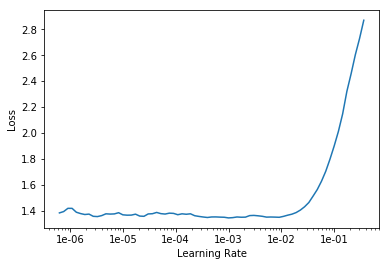

In [37]:
learn.recorder.plot()

In [39]:
learn.save('resnet-50-stage-1')

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-06, 1e-02))

epoch,train_loss,valid_loss,error_rate,time
0,2.963902,1.969311,0.502010,07:57
1,2.330399,1.813103,0.484472,08:03
2,2.102942,1.608946,0.435513,08:00


In [40]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

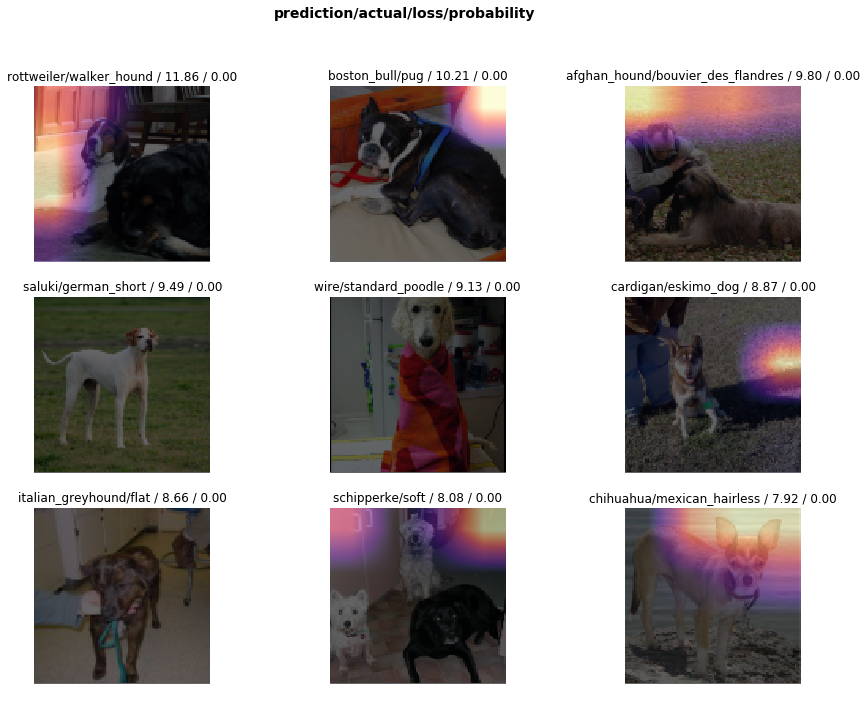

In [41]:
interp.plot_top_losses(9, figsize=(15,11))